<a href="https://colab.research.google.com/github/SirSirocco/DataScience_2025_1/blob/colab/analyse_plan_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEPENDÊNCIAS

In [242]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
from typing import Union
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
from xgboost import XGBRegressor

# FUNÇÕES

## _Ad hoc_

In [243]:
# Constantes simbólicas
_PRE = "pre_processing"              # Pré-processamento
_RF = "random_forest"                # Random Forest
_XGB = "xgboost"                     # XGBoost
_ALL = "all"                         # Todos os modelos considerados simultaneamente

class ExperimentPlan:
    pass
exp = ExperimentPlan()

exp.pre = "pre_processing"
exp.rforest = _RF
exp.xgboost = _XGB
exp.all = _ALL
_ALGORITHM = "algorithm"
_CASE = "case"
_CV_METRIC = "cv_metric"
_FEATURE = "feature"
_FS = "col_rem"
_IMPORTANCE = "importance"
_METRICS = ["mae", "mse", "r2"]
_MODELS = ["RandomForestRegressor", "XGBRegressor"]
_NORM = "normalization"
_OUT = "outliers"
_PCA = "pca"
_FS_SCENARIOS = ["na", "stateless"]

# Raízes
class Radixes:
    pass
rad = Radixes()

rad.test = "best_model_test"
rad.train = "cv_avg"
rad.avg = "cv_avg"
rad.fold = "cv_fold"

In [244]:
def normalize_df_exp_plan_cv(df_exp_plan: pd.DataFrame) -> pd.DataFrame:
    """
    Cada métrica usada na validação cruzada dá origem a uma linha no dataset,
    em vez de condensá-las em uma única linha. Além disso, esta função uniformiza
    os nomes, para que os resultados de diferentes V.C. possam ser comparados entre si.
    """
    METRICS = ["mae", "mse", "r2"]
    CV_RADIX = "_cv_"
    CV_METRIC = _CV_METRIC
    TRAIN_RADIX = "_best_model_test_"
    RENAMING = [x for x in df_exp_plan.columns if CV_RADIX in x or TRAIN_RADIX in x]
    dfs = list()

    # Normaliza DataFrame, gerando uma linha por métrica usada na validação cruzada
    for cv_metric in METRICS:
        # Remove informações da C.V. das outras métricas
        dropping = [x for x in df_exp_plan.columns if not x.startswith(cv_metric) and x in RENAMING]
        df = df_exp_plan.drop(columns=dropping)

        # Retira prefixo com nome da métrica
        mapping_renaming = {x: x.removeprefix(f"{cv_metric}_") for x in RENAMING}
        df = df.rename(columns=mapping_renaming)

        # Indica métrica representada
        df[CV_METRIC] = cv_metric
        dfs.append(df)

    return pd.concat(dfs, axis=0)

In [245]:
def get_avg_coefs(df):
    coef_rows = list()

    for _, row in df.iterrows():
        model_name = row[_ALGORITHM]

        # Converter a string do campo _IMPORTANCE em uma Series
        lines = str(row[_IMPORTANCE]).splitlines()
        for line in lines:
            if line.strip() == "" or line.startswith("dtype:"):
                continue

            try:
                feature, value = line.strip().split()
                coef_rows.append({
                    _FEATURE: feature,
                    _IMPORTANCE: float(value),
                    _ALGORITHM: model_name
                })

            except ValueError:
                continue # Linha mal formatada, ignora

    return pd.DataFrame(coef_rows)

## Constantes

## Exibição

In [246]:
def df_show_head(df: pd.DataFrame, n: int = 5) -> None:
    display(df.head(n))
    print(f"Shape: {df.shape}")

## Utilitário

In [247]:
def compute_ci(x: pd.Series, confidence: int = 0.95):
    """
    Calcula intervalo de confiança (95% por padrão) e retorna também o tamanho da amostra
    """
    a = np.array(x)
    n = len(a)
    mean = a.mean()
    sem = stats.sem(a)
    h = sem * stats.t.ppf((1,0 + confidence) / 2.0, n - 1)
    return mean - h, mean, mean + h, n

# SETUP DO AMBIENTE

In [248]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# OBTENÇÃO DO PLANO DE EXPERIMENTAÇÃO

In [249]:
PATH = "/content/drive/MyDrive/07_per_shared/projCDat_25_1/src/03_experiment_plan/plans/experiment_plan_all.csv"
df_exp_plan = pd.read_csv(PATH)

df_show_head(df_exp_plan)

,case,col_rem,feat_eng,outliers,normalization,pca,n_estimators,max_depth,random_state,algorithm,...,importance,mae_cv_fold_2,mse_cv_fold_2,r2_cv_fold_2,mae_cv_fold_3,mae_cv_fold_4,mse_cv_fold_3,mse_cv_fold_4,r2_cv_fold_3,r2_cv_fold_4
0,FS=na|FE=na|OUT=0|NORM=0|PCA=na|ALGORITHM=rand...,NaN,NaN,False,False,0,100,6,42,RandomForestRegressor,...,_ano 1.491206e-02\n_mes ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FS=na|FE=na|OUT=0|NORM=0|PCA=na|ALGORITHM=rand...,NaN,NaN,False,False,0,100,6,42,RandomForestRegressor,...,_ano 0.017803\n_mes ...,87498.592209,5.205987e+10,0.412158,NaN,NaN,NaN,NaN,NaN,NaN
2,FS=na|FE=na|OUT=0|NORM=0|PCA=na|ALGORITHM=rand...,NaN,NaN,False,False,0,100,6,42,RandomForestRegressor,...,_ano 0.009104\n_mes ...,66236.928523,1.836564e+10,0.588484,70640.52548,93119.710466,3.106546e+10,6.717509e+10,0.596785,0.385069
3,FS=na|FE=na|OUT=0|NORM=0|PCA=5|ALGORITHM=rando...,NaN,NaN,False,False,5,100,6,42,RandomForestRegressor,...,pc1 0.192569\npc2 0.425834\npc3 0.225...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FS=na|FE=na|OUT=0|NORM=0|PCA=5|ALGORITHM=rando...,NaN,NaN,False,False,5,100,6,42,RandomForestRegressor,...,pc1 0.235730\npc2 0.384571\npc3 0.229...,91004.585580,5.274476e+10,0.404424,NaN,NaN,NaN,NaN,NaN,NaN


Shape: (576, 38)


# ANÁLISE

## Análise de Desempenho

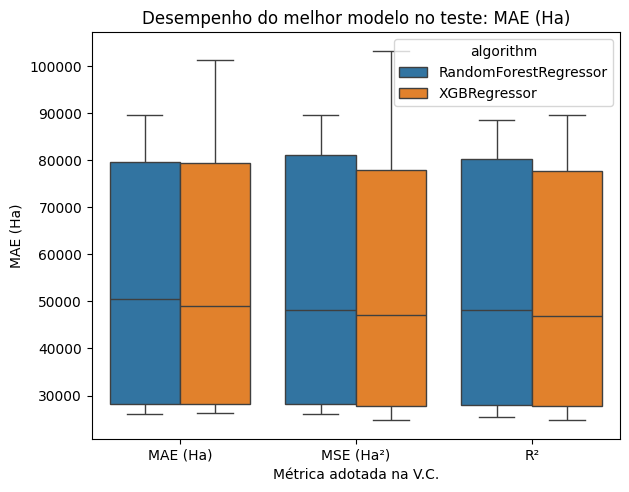

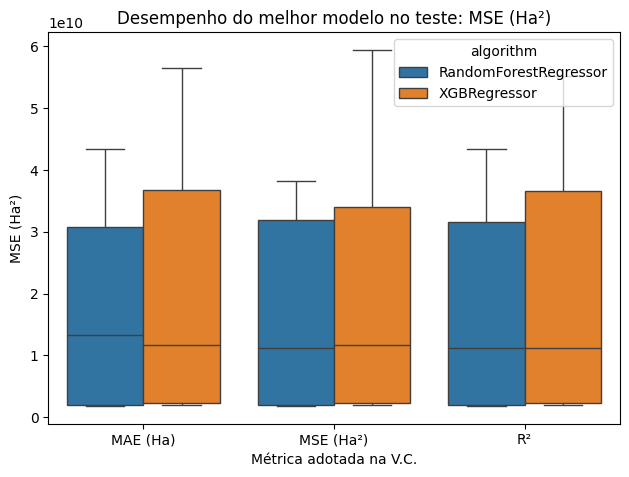

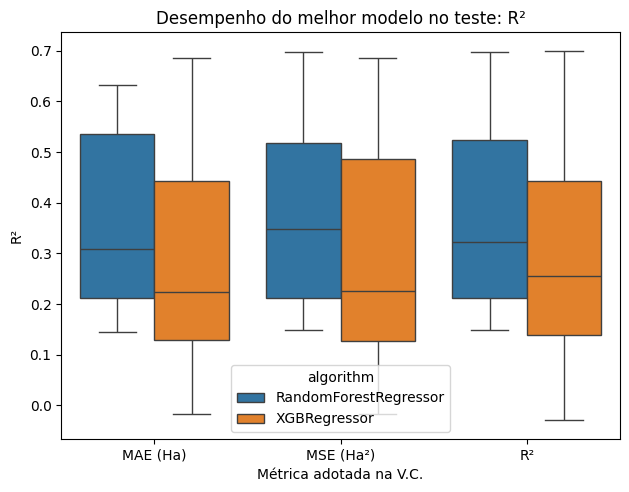

In [250]:
# Formatação (PERF_ remete à performance)
PERF_TITLE = "Desempenho do melhor modelo no teste: {metric}"
PERF_X_AXIS = "Métrica adotada na V.C."
PERF_Y_AXIS = "{metric}"
PERF_MAP_METRICS = {
    "mae": "MAE (Ha)",
    "mse": "MSE (Ha²)",
    "r2": "R²",
}

# Obtém versão normalizada por validação cruzada
df_normalized = normalize_df_exp_plan_cv(df_exp_plan)

# Ajusta formatação das métricas
df_formatted = df_normalized.copy()
df_formatted[_CV_METRIC] = df_formatted[_CV_METRIC].map(PERF_MAP_METRICS)

# Exibe resultados das métricas por melhor cenário das validações cruzadas
for metric, mapped in PERF_MAP_METRICS.items():
    metric_col = f"best_model_test_{metric}"

    sns.boxplot(data=df_formatted, x=_CV_METRIC, y=metric_col, hue=_ALGORITHM)
    plt.tight_layout()
    plt.title(PERF_TITLE.format(metric=mapped))
    plt.xlabel(PERF_X_AXIS)
    plt.ylabel(PERF_Y_AXIS.format(metric=mapped))
    plt.show()

    print("\n") # Respiro visual

In [251]:
# Formatação
PERF_TABLE_TITLE = "### Tabela comparativa de performance ###"

# Armazena resultados a comporem a tabela de desempenho
perf_data = {
    "modelo": [],
    "métrica": [],
    "média": [],
    "desvio padrão": []
}

# Constrói tabela comparativa de métricas
for metric, formatted in PERF_MAP_METRICS.items():
    for model in _MODELS:
        perf_data["métrica"].append(formatted)
        perf_data["modelo"].append(model)

        df_model = df_normalized[df_normalized[_ALGORITHM] == model]

        perf_data["média"].append(df_model[f"best_model_test_{metric}"].mean()) # Computa média
        perf_data["desvio padrão"].append(df_model[f"best_model_test_{metric}"].std()) # Computa desvio padrão
df_perf_cmp_table = pd.DataFrame(data=perf_data)

# Exibe tabela
print(PERF_TABLE_TITLE)
display(df_perf_cmp_table)

### Tabela comparativa de performance ###


,modelo,métrica,média,desvio padrão
0,RandomForestRegressor,MAE (Ha),5.397250e+04,2.639074e+04
1,XGBRegressor,MAE (Ha),5.346785e+04,2.616983e+04
2,RandomForestRegressor,MSE (Ha²),1.659436e+10,1.497225e+10
3,XGBRegressor,MSE (Ha²),1.875545e+10,1.742265e+10
4,RandomForestRegressor,R²,3.719583e-01,1.693104e-01
5,XGBRegressor,R²,2.996112e-01,1.937303e-01


### Análise

## Análise de Coeficientes

Para assegurar a interpretabilidade, serão considerados apenas os casos sem PCA aplicado, isto é, com `PCA=0`.

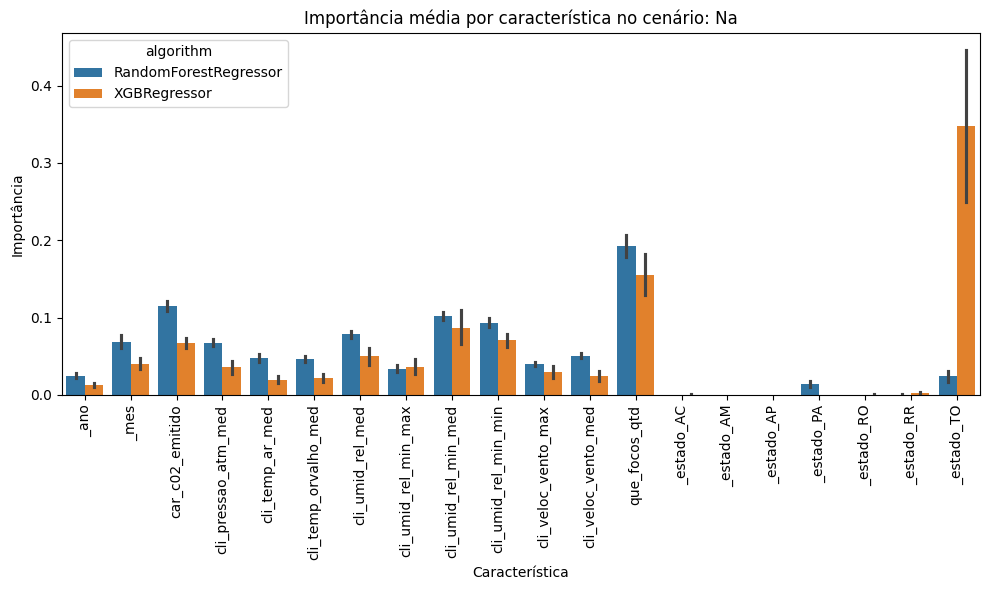

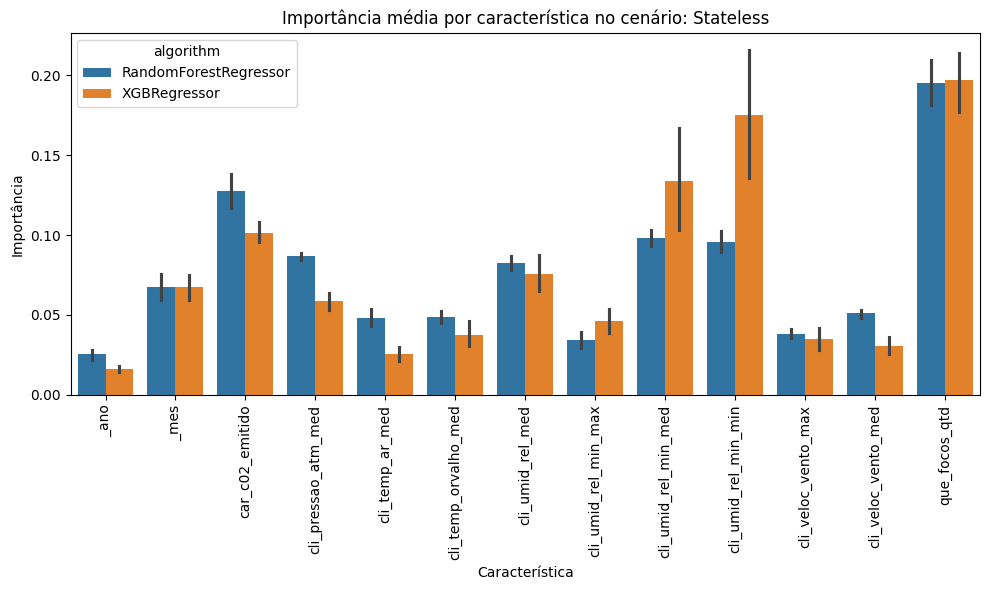

In [252]:
# Constantes auxiliares
COEF_MASK = "FS={scenario}"
COEF_ALPHA = 5 # %

# Formatação
COEF_TITLE = "Importância média por característica no cenário: {scenario}"
COEF_X_AXIS = "Característica"
COEF_Y_AXIS = "Importância"

# Obtém cenários sem PCA aplicado
df_pcaless = df_exp_plan[df_exp_plan[_PCA] == 0]

for scenario in _FS_SCENARIOS:
    # Filtra o cenário de seleção de features desejado
    df_scenario = df_pcaless[
        df_pcaless[_CASE].apply(
            lambda key: COEF_MASK.format(scenario=scenario) in key
        )
    ]

    # Obtém DataFrame com a média dos coeficientes
    df_avg_coefs = get_avg_coefs(df_scenario)

    """
    Plota gráfico de barras da média por coeficiente com intervalo de confiança
    ao nível de significância alfa
    """
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=df_avg_coefs,
        x=_FEATURE,
        y=_IMPORTANCE,
        hue=_ALGORITHM,
        errorbar=("ci", 100 - COEF_ALPHA)
    )
    plt.title(COEF_TITLE.format(scenario=scenario.capitalize()))
    plt.xlabel(COEF_X_AXIS)
    plt.ylabel(COEF_Y_AXIS)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    print("\n") # Respiro visual

### Análise

## Análise de Cenários de Pré-Processamento

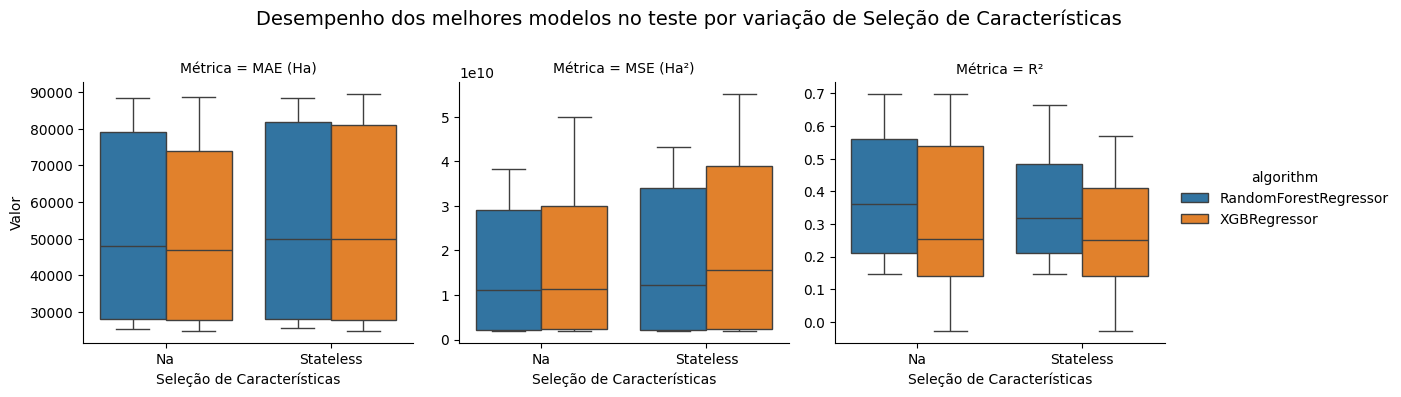

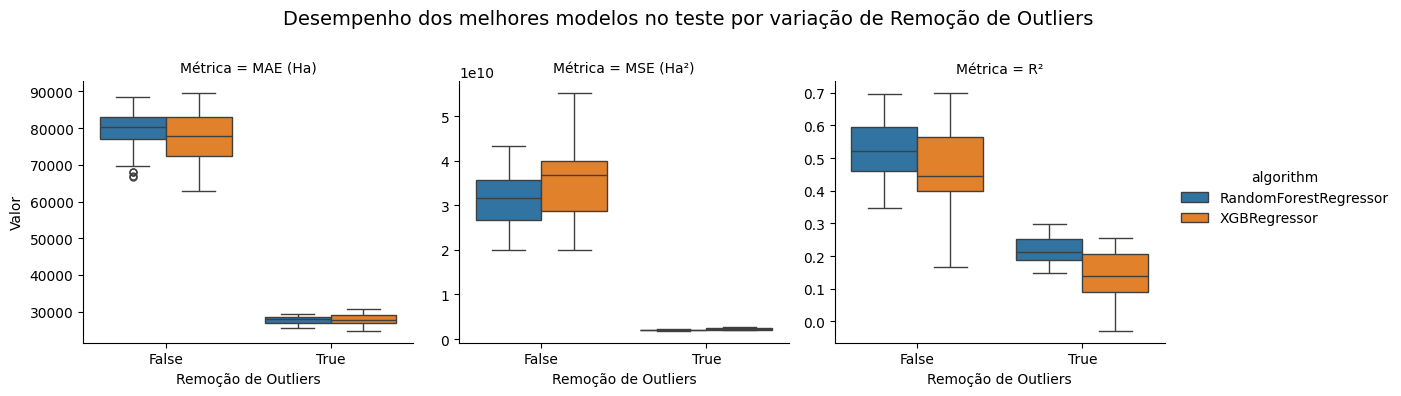

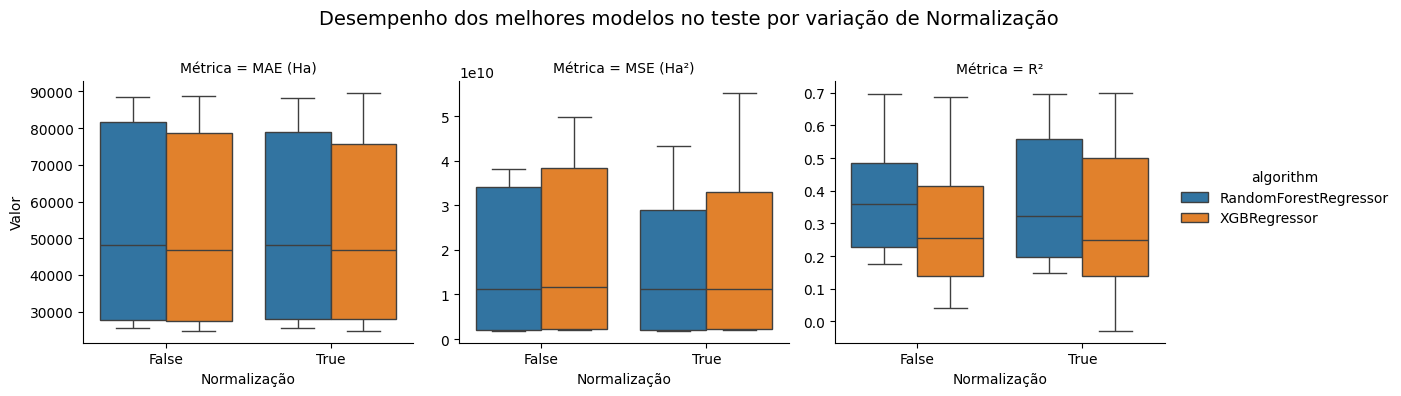

In [253]:
# Constantes auxiliares
PRE_MASK = "FS={scenario}"
PRE_REF_METRIC = "r2" # Métrica de referência usada na V.C.

PRE_STEPS_MAP = {
    _FS: "Seleção de Características",
    _OUT: "Remoção de Outliers",
    _NORM: "Normalização"
}

PRE_MAP_METRICS = {
    f"{_TEST_RADIX}_mae": "MAE (Ha)",
    f"{_TEST_RADIX}_mse": "MSE (Ha²)",
    f"{_TEST_RADIX}_r2": "R²",
}

# Formatação
PRE_PLOT = "box"
PRE_METRIC = "Métrica"
PRE_TITLE = "Desempenho dos melhores modelos no teste por variação de {step_name}"
PRE_Y_AXIS = "Valor"

# Restringe apenas aos casos que tenham usado a métrica de referência em sua V.C.
df_pre = normalize_df_exp_plan_cv(df_exp_plan)
df_pre = df_pre[df_pre[_CV_METRIC] == PRE_REF_METRIC]
df_pre = df_pre.rename(columns=PRE_MAP_METRICS)

# Renomeia cenários
for scenario in _FS_SCENARIOS:
    df_pre.loc[
        df_pre[_CASE].apply(lambda key: PRE_MASK.format(scenario=scenario) in key),
        _FS
    ] = scenario.capitalize()

for step, step_name in PRE_STEPS_MAP.items():
    # Transforma DataFrame para formato longo
    df_melted = df_pre.melt(
        id_vars=[_ALGORITHM, step],  # Colunas que permanecem
        value_vars=[metric for metric in PRE_MAP_METRICS.values()],  # Métricas
        var_name= PRE_METRIC,
        value_name=PRE_Y_AXIS
    )

    # Plota subgráficos: um por variação do pré-processamento
    g = sns.catplot(
        data=df_melted,
        kind=PRE_PLOT,
        x=step,
        y=PRE_Y_AXIS,
        hue=_ALGORITHM,
        col=PRE_METRIC,
        col_wrap=3,     # Controla quantos gráficos por linha
        height=4,
        aspect=1,
        sharey=False    # Gráficos não compartilham escala
    )
    g.fig.subplots_adjust(top=0.8)
    g.fig.suptitle(PRE_TITLE.format(step_name=step_name), fontsize=14)
    g.set_axis_labels(step_name, PRE_Y_AXIS)
    plt.show()

    print("\n")

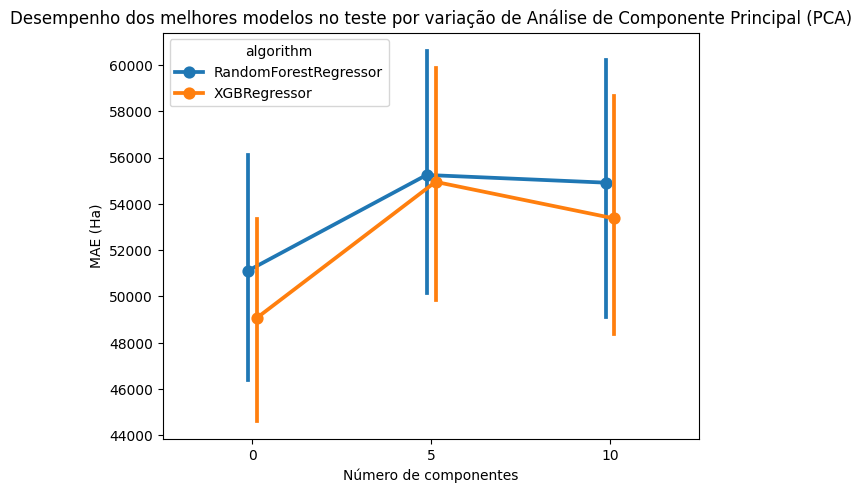

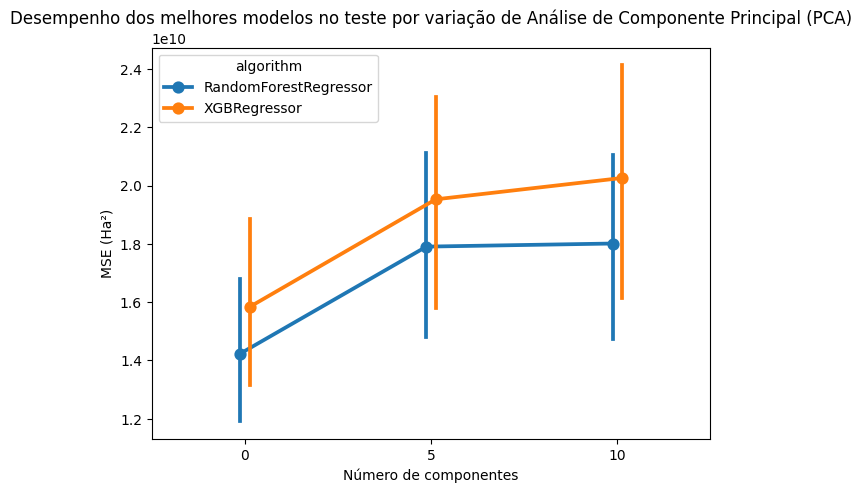

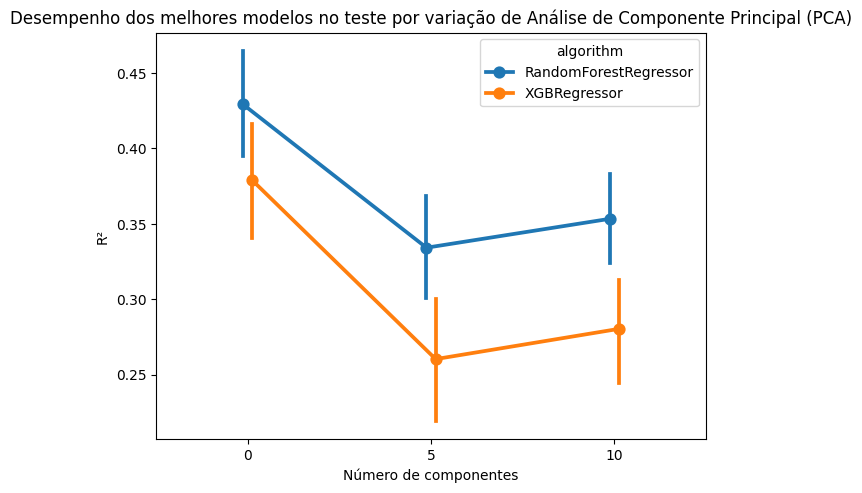

In [254]:
PRE_PCA = "Análise de Componente Principal (PCA)"
PRE_PCA_X_AXIS = "Número de componentes"

# Exibe pointplot por métrica
for metric in PRE_MAP_METRICS.values():
    sns.pointplot(data=df_pre,
                  x=_PCA,
                  y=metric,
                  hue=_ALGORITHM,
                  dodge=True        # Evita sobreposição
                  )
    plt.tight_layout()
    plt.title(PRE_TITLE.format(step_name=PRE_PCA))
    plt.xlabel(PRE_PCA_X_AXIS)
    plt.show()

    print("\n")

### Análise

## Validação Cruzada

## Intervalos de Confiança

In [257]:
def get_train_series_per_metric(df_exp_plan: pd.DataFrame, metric):
    train_cols = [col for col in df_exp_plan.columns if _CV_FOLD_RADIX in col and metric in col]

    series = list()
    for col in train_cols:
        series.append(df_exp_plan[col])

    return pd.concat(series, axis=0)

def get_test_series_per_metric(df_exp_plan: pd.DataFrame, metric):
    test_cols = [col for col in df_exp_plan.columns if _TEST_RADIX in col and col.endswith(metric)]

    series = list()
    for col in test_cols:
        series.append(df_exp_plan[col])

    return pd.concat(series, axis=0)


CI_ALPHA = 0.05
CI_CONFIDECE = 1.0 - CI_ALPHA

# Formatação
CI_AVG = "Ponto médio"
CI_N = "Tamanho da amostra"
CI_LIM_INF = "Limite inferior"
CI_LIM_SUP = "Limite superior"
CI_DATASET = "Conjunto"
CI_DATASETS_MAP = {
    _TRAIN_RADIX: "Treino",
    _TEST_RADIX: "Teste"
}
CI_MAP_METRICS = {
    "mae": "MAE (Ha)",
    "mse": "MSE (Ha²)",
    "r2": "R²",
}

ci_data = {
    _ALGORITHM: [],
    CI_DATASET: [],
    CI_LIM_INF: [],
    CI_AVG: [],
    CI_LIM_SUP: [],
}

df_ci = df_exp_plan.copy()
print(df_ci.columns)
for model in _ALGORITHM:
    for metric in _METRICS:
        ci_data[_ALGORITHM].append(model)
        ci_data[CI_DATASET].append(CI_DATASETS_MAP[_TRAIN_RADIX])


        col_metric = f"{radix}_{metric}"
        se_metric = df_ci[col_metric]
        ci_inf, ci_avg, ci_sup, ci_n = compute_ci(se_metric, CI_CONFIDECE)

        ci_data[CI_LIM_INF].append(ci_inf)
        ci_data[CI_AVG].append(ci_avg)
        ci_data[CI_LIM_SUP].append(ci_sup)
        ci_data[CI_N].append(ci_n)

df_ci = pd.DataFrame(data=ci_data)
display(df_ci)

Index(['case', 'col_rem', 'feat_eng', 'outliers', 'normalization', 'pca',
       'n_estimators', 'max_depth', 'random_state', 'algorithm', 'cv_fold_0',
       'cv_fold_1', 'cv_avg', 'best_model_test_mae', 'best_model_test_mse',
       'best_model_test_r2', 'importance', 'cv_fold_2', 'cv_fold_3',
       'cv_fold_4', 'cv_metric'],
      dtype='object')


KeyError: 'cv_avg_mae'

## Interpretação dos Resultados

--- Escreva aqui a interpretação ---

## Visualização dos Resultados para Escolha do Melhor Modelo

## Escolha do Melhor Modelo